In [2]:
import pennylane as qml
import matplotlib.pyplot as plt

from scipy.optimize import differential_evolution
from scipy.stats.qmc import Halton

import os
import json
import numpy as np
from datetime import datetime, timedelta
import time

from susy_qm import calculate_Hamiltonian

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes

In [3]:
potential = "DW"
#shots = None
cutoff = 16

print(f"Running for {potential} potential and cutoff {cutoff}")

starttime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Calculate Hamiltonian and expected eigenvalues
H = calculate_Hamiltonian(cutoff, potential)
eigenvalues = np.sort(np.linalg.eig(H)[0])[:4]
min_eigenvalue = np.min(eigenvalues).real

num_qubits = int(1 + np.log2(cutoff))

Running for DW potential and cutoff 16


In [4]:
def cost_function(params, H, num_qubits, shots):
    dev = qml.device("default.qubit", wires=num_qubits, shots=shots)
    start = datetime.now()

    @qml.qnode(dev)
    def circuit(params):
        param_index = 0
        for i in range(num_qubits):
            qml.RY(params[param_index], wires=i)
            param_index += 1

        for j in reversed(range(1, num_qubits)):
            qml.CNOT(wires=[j, j-1])

        for k in range(num_qubits):
            qml.RY(params[param_index], wires=k)
            param_index += 1

        return qml.sample(qml.Hermitian(H, wires=range(num_qubits)))

    samples = circuit(params)
    energy = np.mean(samples)
    variance = np.var(samples, ddof=1)  #sample variance

    end = datetime.now()
    device_time = end - start

    return energy, variance, device_time


In [10]:
def run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots, num_params):

    generation_best_energies = []
    generation_best_params = []
    generation_best_variances = []
    current_generation = [0]

    def callback(xk, convergence=None):
     
        best_energy, variance, _ = cost_function(xk, H, num_qubits, shots)
        generation_best_energies.append(best_energy)
        generation_best_params.append(xk.tolist())
        generation_best_variances.append(variance)

        current_generation[0] += 1

    # We need to generate a random seed for each process otherwise each parallelised run will have the same result
    seed = (os.getpid() * int(time.time())) % 123456789
    run_start = datetime.now()

    # Generate Halton sequence
    num_dimensions = num_params
    num_samples = popsize
    halton_sampler = Halton(d=num_dimensions, seed=seed)
    halton_samples = halton_sampler.random(n=num_samples)
    scaled_samples = 2 * np.pi * halton_samples

    device_time = timedelta()

    evaluation_log = []
    def wrapped_cost_function(params):
        result, variance, dt = cost_function(params, H, num_qubits, shots)
        nonlocal device_time
        device_time += dt
        evaluation_log.append((current_generation[0], result, variance))
        return result

    # Differential Evolution optimization
    res = differential_evolution(
        wrapped_cost_function,
        bounds,
        maxiter=max_iter,
        tol=tol,
        atol=abs_tol,
        strategy=strategy,
        popsize=popsize,
        init=scaled_samples,
        seed=seed,
        callback=callback
    )

    run_end = datetime.now()
    run_time = run_end - run_start

    return {
        "seed": seed,
        "energy": res.fun,
        "params": res.x.tolist(),
        "success": bool(res.success),
        "num_iters": res.nit,
        "num_evaluations": res.nfev,
        "run_time": str(run_time),
        "device_time": str(device_time),
        "generation_best_energies": generation_best_energies,
        "generation_best_params": generation_best_params,
        "generation_best_variances": generation_best_variances,
        "evaluation_log": evaluation_log
    }

In [11]:
num_params = 2*num_qubits
bounds = [(0, 2 * np.pi) for _ in range(num_params)]

num_vqe_runs = 1
max_iter = 10000
strategy = "randtobest1bin"
tol = 1e-3
abs_tol = 1e-3
popsize = 20

#shot_list = [1024, 2048, 4096, 8192, 16384, 32768, None]
#shot_list = [64, 256, 1024, 4096, 16384, 65536]
shot_list = [64, 1024, 65536]
all_data = []

for shots in shot_list:

    data = run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots=shots, num_params=num_params)
    all_data.append(data)


In [12]:
# Save the variable to a JSON file
base_path = r"C:\Users\Johnk\Documents\PhD\Quantum Computing Code\Quantum-Computing\SUSY\SUSY QM\PennyLane\VQE\Differential Evolution\VarianceFromShotsCheck\SingleRunFiles"
path = os.path.join(base_path, "VarShotsPlot_{}.json".format(str(datetime.now().date())))
with open(path, "w") as json_file:
    json.dump(all_data, json_file, indent=4)

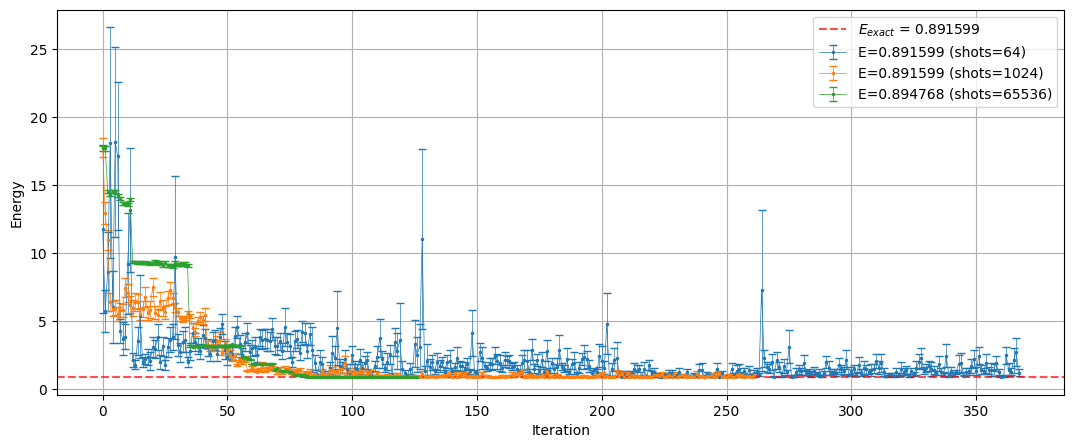

In [14]:
plt.figure(figsize=(13, 5))

for i, d in enumerate(all_data):

    shots = shot_list[i]
    energies = d["generation_best_energies"]#[:250]
    variances = d["generation_best_variances"]#[:250]
    std = np.sqrt(variances) / np.sqrt(shots)
    generations = np.arange(len(energies))
    plt.errorbar(generations, energies, yerr=std, fmt='-o', linewidth=0.5, markersize=1.5, capsize=3, label=f"E={format(d['energy'], '.6g')} (shots={shots})")

plt.axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7, label='$E_{exact}$'+f' = {format(min_eigenvalue, '.6g')}')
plt.legend()
plt.ylabel("Energy")
plt.xlabel("Iteration")
plt.grid(True)

In [24]:
def run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots, num_params):

    generation_best_energies = []
    generation_best_params = []
    generation_best_variances = []
    current_generation = [0]
    best_so_far = {"energy": np.inf, "params": None, "gen": None}


    def callback(xk, convergence=None):
     
        best_energy, variance, _ = cost_function(xk, H, num_qubits, shots)
        generation_best_energies.append(best_energy)
        generation_best_params.append(xk.tolist())
        generation_best_variances.append(variance)

        if best_energy < best_so_far["energy"]:
            best_so_far["energy"] = best_energy
            best_so_far["params"] = xk.copy()
            best_so_far["gen"] = current_generation[0]

        current_generation[0] += 1

    # We need to generate a random seed for each process otherwise each parallelised run will have the same result
    #seed = (os.getpid() * int(time.time())) % 123456789
    seed = 105419366
    run_start = datetime.now()

    # Generate Halton sequence
    num_dimensions = num_params
    num_samples = popsize
    halton_sampler = Halton(d=num_dimensions, seed=seed)
    halton_samples = halton_sampler.random(n=num_samples)
    scaled_samples = 2 * np.pi * halton_samples

    device_time = timedelta()

    evaluation_log = []
    def wrapped_cost_function(params):
        result, variance, dt = cost_function(params, H, num_qubits, shots)
        nonlocal device_time
        device_time += dt
        evaluation_log.append((current_generation[0], result, variance))
        return result

    # Differential Evolution optimization
    res = differential_evolution(
        wrapped_cost_function,
        bounds,
        maxiter=max_iter,
        tol=tol,
        atol=abs_tol,
        strategy=strategy,
        popsize=popsize,
        init=scaled_samples,
        seed=seed,
        callback=callback
    )

    run_end = datetime.now()
    run_time = run_end - run_start

    res_fun_generation = None
    for gen_idx, params in enumerate(generation_best_params):
        if np.allclose(params, res.x, atol=1e-6):
            res_fun_generation = gen_idx
            break

    return {
        "seed": seed,
        "energy": res.fun,
        "params": res.x.tolist(),
        "success": bool(res.success),
        "num_iters": res.nit,
        "num_evaluations": res.nfev,
        "run_time": str(run_time),
        "device_time": str(device_time),
        "generation_best_energies": generation_best_energies,
        "generation_best_params": generation_best_params,
        "generation_best_variances": generation_best_variances,
        "evaluation_log": evaluation_log,
        "res_fun_generation": res_fun_generation
    }

In [31]:
num_params = 2*num_qubits
bounds = [(0, 2 * np.pi) for _ in range(num_params)]

num_vqe_runs = 1
max_iter = 10000
strategy = "randtobest1bin"
tol = 1e-3
abs_tol = 1e-3
popsize = 20

#shot_list = [1024, 2048, 4096, 8192, 16384, 32768, None]
#shot_list = [64, 256, 1024, 4096, 16384, 65536]
shot_list = [64, 1024, 65536]
all_data = []

for shots in shot_list:

    data = run_de_vqe(bounds, max_iter, tol, abs_tol, strategy, popsize, H, num_qubits, shots=shots, num_params=num_params)
    all_data.append(data)


219
125
133


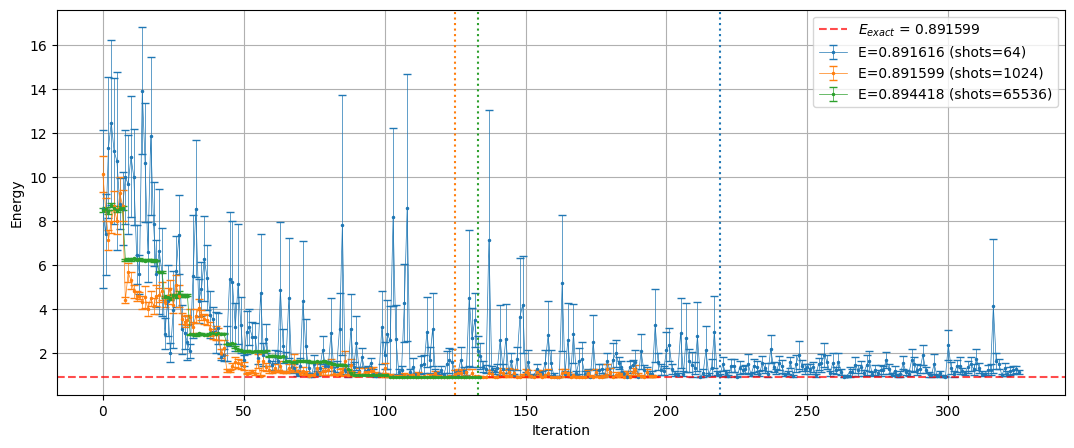

In [34]:
plt.figure(figsize=(13, 5))

for i, d in enumerate(all_data):

    shots = shot_list[i]
    energies = d["generation_best_energies"]
    variances = d["generation_best_variances"]
    std = np.sqrt(variances) / np.sqrt(shots)
    generations = np.arange(len(energies))

    # Plot errorbar and keep a reference to the line
    err = plt.errorbar(
        generations,
        energies,
        yerr=std,
        fmt='-o',
        linewidth=0.5,
        markersize=1.5,
        capsize=3,
        label=f"E={format(d['energy'], '.6g')} (shots={shots})"
    )

    # Get the color used for this line
    line_color = err[0].get_color()

    # Add vertical line at the generation where res.fun was found
    gen_found = d["res_fun_generation"]
    print(gen_found)
    plt.axvline(
    x=gen_found,
    color=line_color,
    linestyle=':',
    linewidth=1.5,
    alpha=1.0)
    

# Exact energy reference
plt.axhline(
    y=min_eigenvalue,
    color='red',
    linestyle='--',
    alpha=0.7,
    label='$E_{exact}$'+f' = {format(min_eigenvalue, ".6g")}'
)

plt.legend()
plt.ylabel("Energy")
plt.xlabel("Iteration")
plt.grid(True)


In [ ]:
fig, ax = plt.subplots(figsize=(13, 5))

for i, d in enumerate(all_data):
    shots = shot_list[i]
    energies = d["generation_best_energies"][:250]
    variances = d["generation_best_variances"][:250]
    std = np.sqrt(variances) / np.sqrt(shots)
    generations = np.arange(len(energies))
    ax.errorbar(generations, energies, yerr=std, fmt='-o', linewidth=0.5, markersize=1.5, capsize=3,
                label=f"E={format(d['energy'], '.6g')} (shots={shots})")

ax.axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7,
           label='$E_{exact}$' + f' = {format(min_eigenvalue, ".6g")}')
ax.legend()
ax.set_ylabel("Energy")
ax.set_xlabel("Iteration")
ax.grid(True)


axins = inset_axes(ax, width="35%", height="35%", loc='center right', borderpad=2)
all_yvals = []
for i, d in enumerate(all_data):
    shots = shot_list[i]
    energies = d["generation_best_energies"]
    variances = d["generation_best_variances"]
    
    if len(energies) > 125:
        start = 125
        end = min(len(energies), 226)
        x = np.arange(start, end)
        y = energies[start:end]
        yerr = np.sqrt(variances[start:end]) / np.sqrt(shots)
        axins.errorbar(x, y, yerr=yerr, fmt='-o', linewidth=0.5, markersize=1.5, capsize=2)
        all_yvals.extend(y)

axins.set_xlim(125, 225)


if all_yvals:
    y_min = min(all_yvals) - 0.5
    y_max = max(all_yvals) + 0.5
    axins.set_ylim(y_min, y_max)
    axins.set_ylim(0.8, 2.1)


axins.axhline(y=min_eigenvalue, color='red', linestyle='--', alpha=0.7)

axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

#plt.tight_layout()
plt.show()
